In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as sta
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)
%matplotlib inline

In [2]:
train_df = pd.read_csv('D:/DataAnalysis/2019未来高校AI挑战赛_城市-房产租金预测/train_data.csv')
test_df = pd.read_csv('D:/DataAnalysis/2019未来高校AI挑战赛_城市-房产租金预测/test_a.csv')

In [3]:
train_df.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


train_df.info()

### 1.训练集和测试集的空值统计

In [4]:
combine = [train_df,test_df]
for data_index in combine:
    Total = data_index.isnull().sum().sort_values(ascending=False)
    Percent = Total/data_index.isnull().count()
    Missing_count = pd.concat([Total,Percent],axis=1,keys=["Total","Percent"],sort=False)
    print("-----------------------------------------------------------------------------")
    print(Missing_count[Missing_count.Total>0])

-----------------------------------------------------------------------------
    Total   Percent
uv     18  0.000434
pv     18  0.000434
-----------------------------------------------------------------------------
    Total  Percent
uv      2  0.00081
pv      2  0.00081


我们可以看到：pv和uv都有少量的缺失值，其中pv表示该板块当月租客浏览网页次数，uv表示该板块当月租客浏览网页总人数　。这里，我们可以使用均值，
中位数，众数等简单的方法进行填充。

In [5]:
fill_na = ["uv","pv"]
for fill in fill_na:
    train_df[fill].fillna(train_df[fill].mean(),inplace=True)
    test_df[fill].fillna(test_df[fill].mean(),inplace=True)
    train_df[fill] = train_df[fill].astype(int)
    test_df[fill] = test_df[fill].astype(int)

### 2.预测变量的峰度和偏度分析

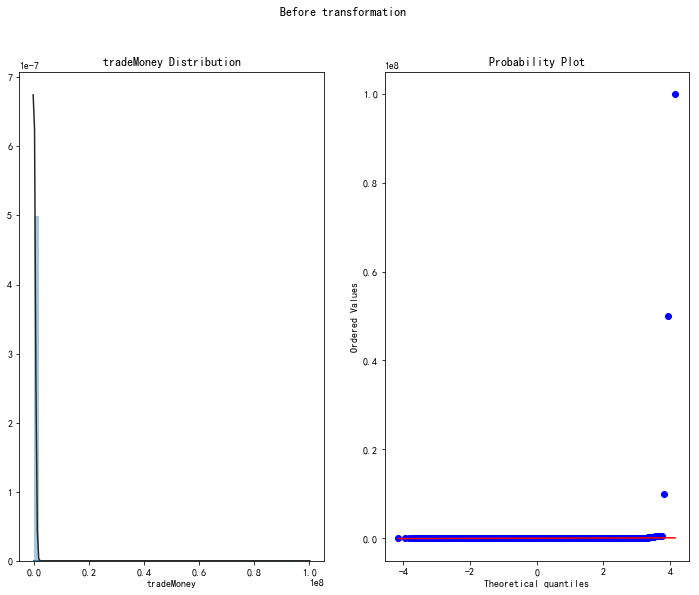

In [6]:
#预测变量的分布

plt.rcParams['font.sans-serif']=['SimHei']##显示中文标签
plt.rcParams['axes.unicode_minus']=False##显示正负号
fig ,(ax1,ax2) = plt.subplots(1,2,figsize=(12,9))
sns.distplot(train_df["tradeMoney"],fit=norm,ax=ax1)
ax1.set_title("tradeMoney Distribution")
sta.probplot(train_df["tradeMoney"],plot=ax2)
plt.suptitle("Before transformation")
plt.show()

In [7]:
#分块分析一下
#pd.qcut(train_df['tradeMoney'],q=4)
train_df["tradeMoney"].describe()

count    4.144000e+04
mean     8.837074e+03
std      5.514287e+05
min      0.000000e+00
25%      2.800000e+03
50%      4.000000e+03
75%      5.500000e+03
max      1.000000e+08
Name: tradeMoney, dtype: float64

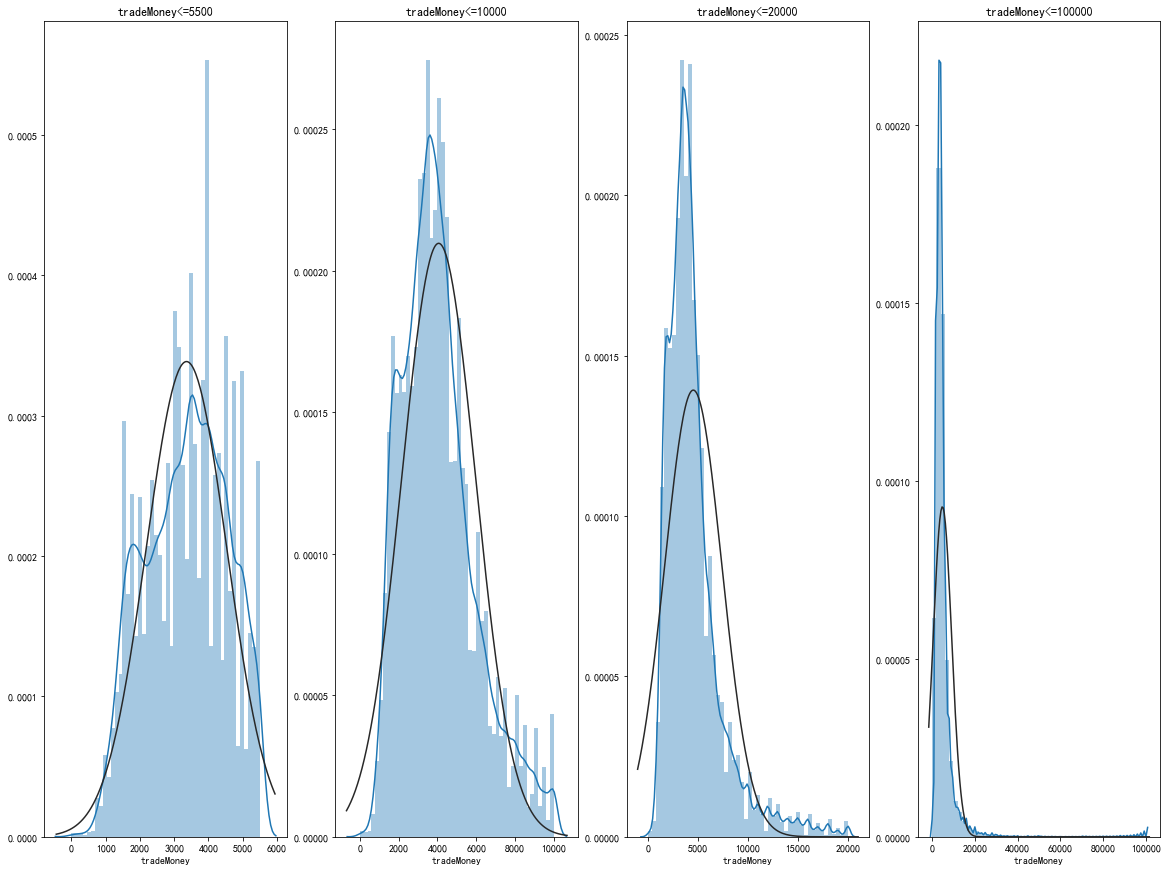

In [8]:
#tradeMoney
tradeMoney_1 = train_df.loc[train_df["tradeMoney"]<=5500,"tradeMoney"]
tradeMoney_2 = train_df.loc[train_df["tradeMoney"]<=10000,"tradeMoney"]
tradeMoney_3 = train_df.loc[train_df["tradeMoney"]<=20000,"tradeMoney"]
tradeMoney_4 = train_df.loc[train_df["tradeMoney"]<=100000,"tradeMoney"]
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(20,15))
sns.distplot(tradeMoney_1,fit=norm,ax=ax1)
ax1.set_title("tradeMoney<=5500")
sns.distplot(tradeMoney_2,fit=norm,ax=ax2)
ax2.set_title("tradeMoney<=10000")
sns.distplot(tradeMoney_3,fit=norm,ax=ax3)
ax3.set_title("tradeMoney<=20000")
sns.distplot(tradeMoney_4,fit=norm,ax=ax4)
ax4.set_title("tradeMoney<=100000")
plt.show()

可以看出来，大于5500的数据分布不符合正态分布，删掉

In [9]:
train_df = train_df[(train_df['tradeMoney']<=20000)&(train_df['tradeMoney']>=100)]
train_df['tradeMoney'] = np.log1p(train_df['tradeMoney'])

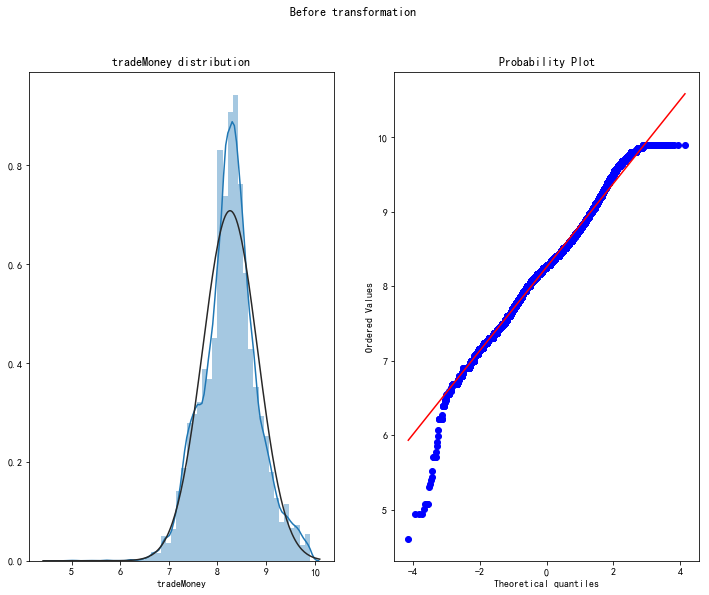

In [10]:
fig = plt.figure(figsize=(12,9))
ax1 = fig.add_subplot(121)
sns.distplot(train_df['tradeMoney'],fit=norm)
plt.title('tradeMoney distribution')
ax2 = fig.add_subplot(122)
sta.probplot(train_df['tradeMoney'],plot=plt)
plt.suptitle('Before transformation')
plt.show()



后面我们需要对数据做进一步的处理，使其符合正太分布，一般使用对数转换。

In [11]:
#计算峰度和偏度

In [12]:
print("Skewness:%f"%train_df['tradeMoney'].skew())
print("Kurtness:%f"%train_df['tradeMoney'].kurt())

Skewness:0.000971
Kurtness:0.614985


### 3.单调特征列

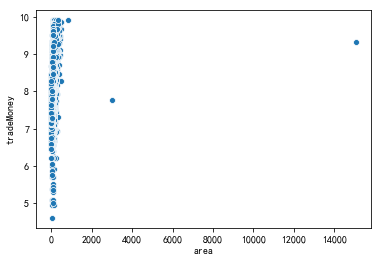

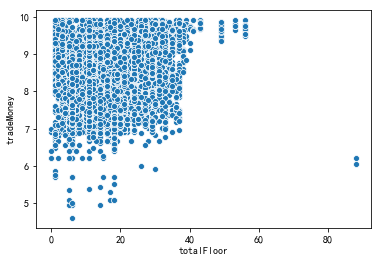

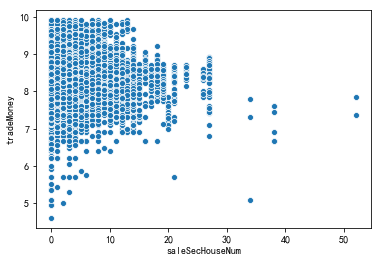

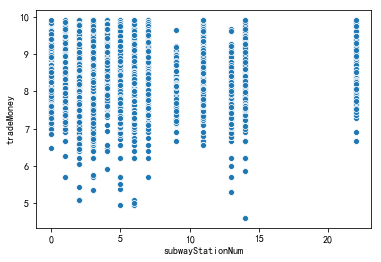

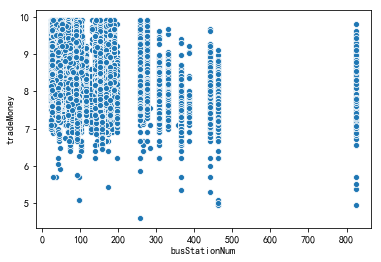

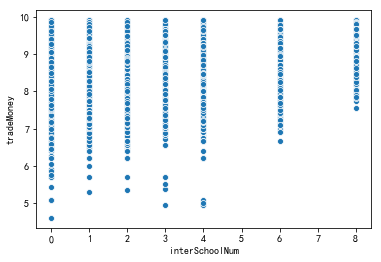

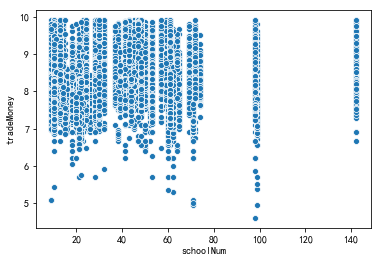

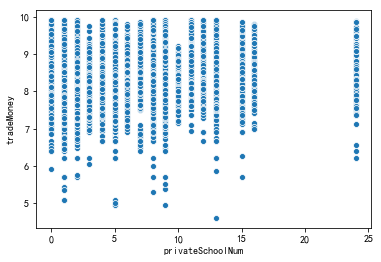

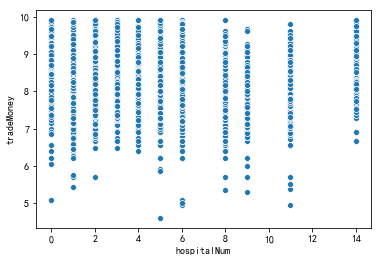

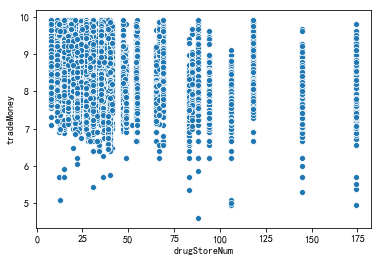

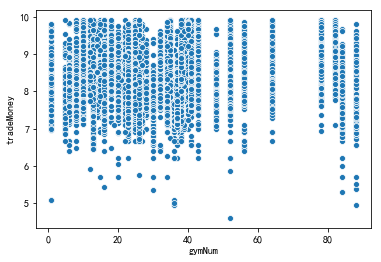

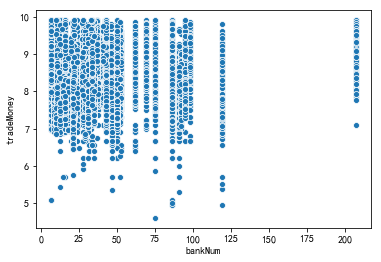

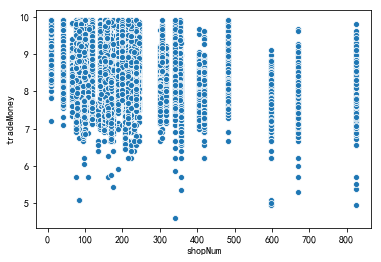

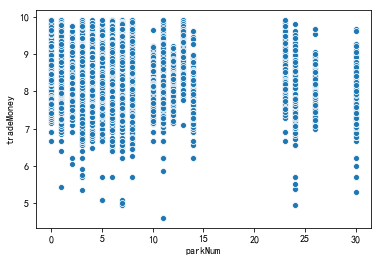

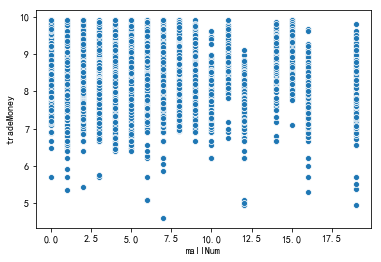

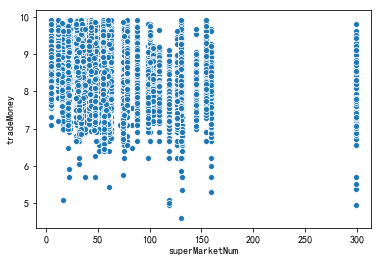

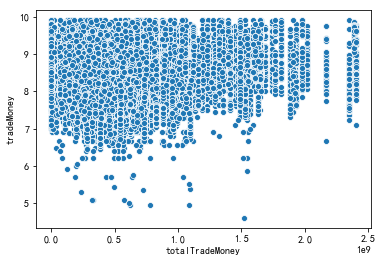

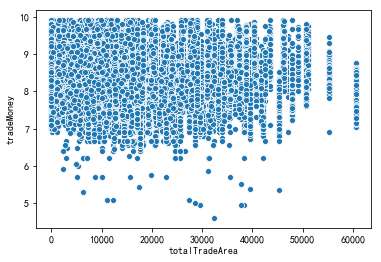

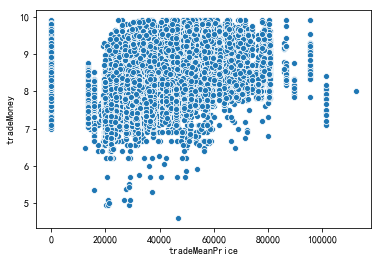

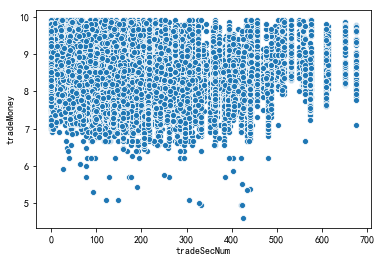

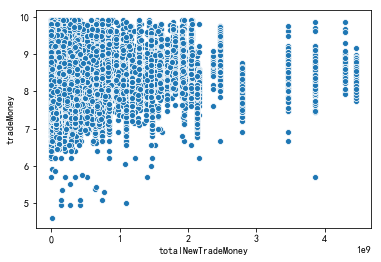

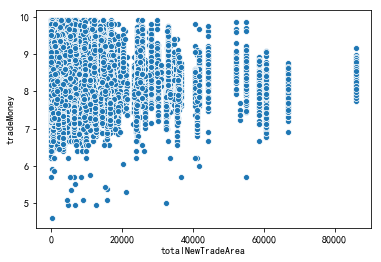

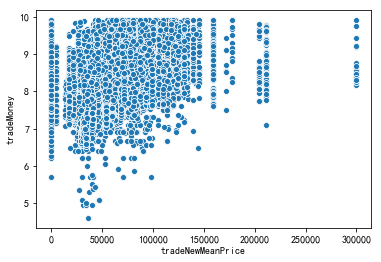

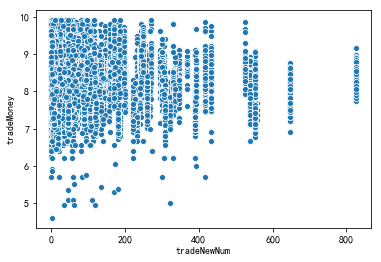

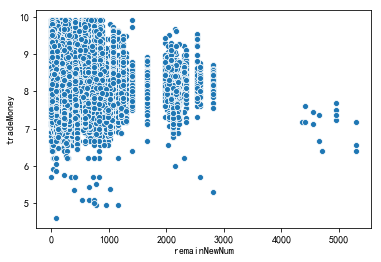

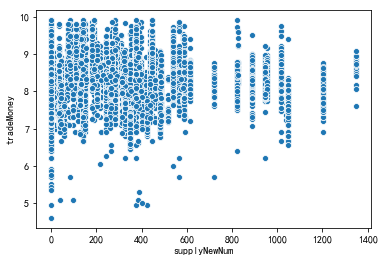

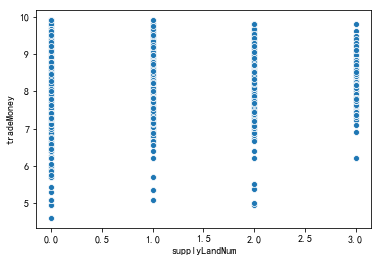

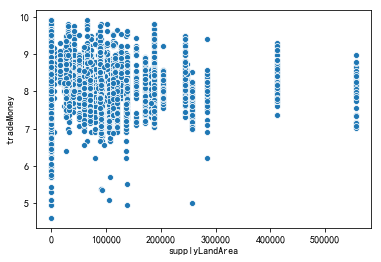

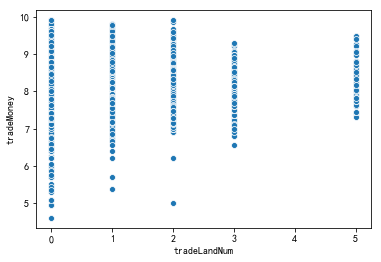

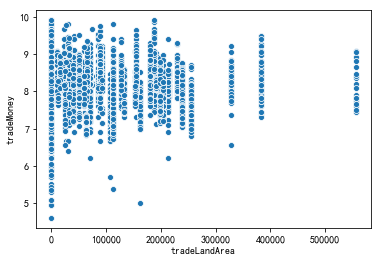

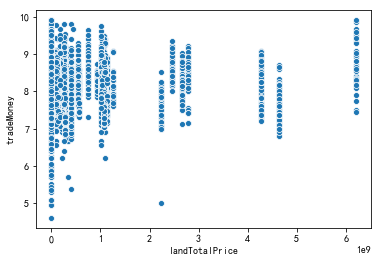

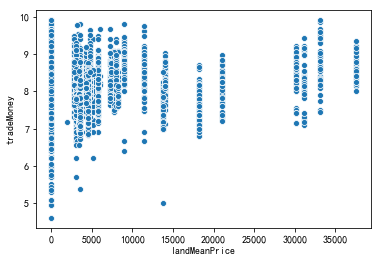

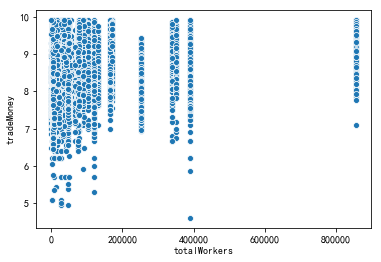

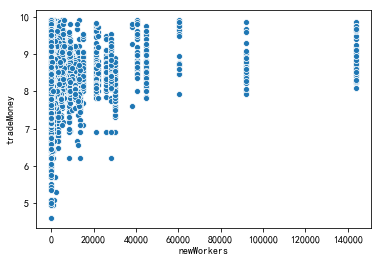

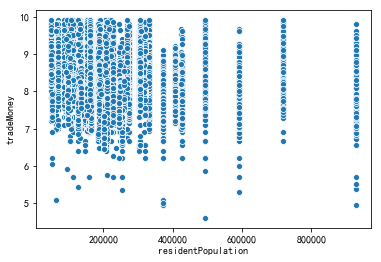

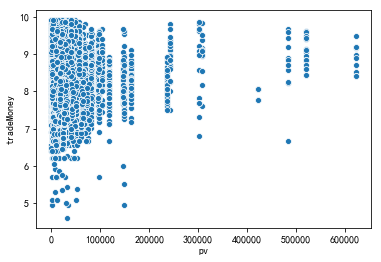

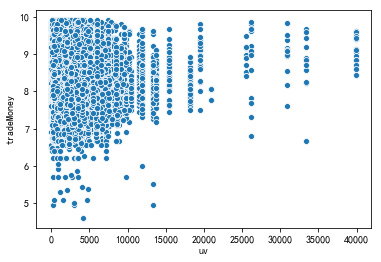

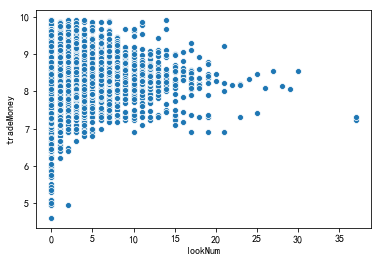

In [13]:
numerical_col = [col for col in train_df.columns if train_df[col].dtypes!="object" 
                 and col not in ["ID","tradeMoney"]]
categorical_col = train_df.select_dtypes(include=["object"]).columns
y = train_df["tradeMoney"]

for col in numerical_col:
    #plt.figure(figsize=(10,6))
    sns.scatterplot(train_df[col],y)
    plt.show()

### 4.Categorical特征nunique分布

In [14]:
train_nunique = train_df[categorical_col].nunique().sort_values(ascending=False)
test_nunique = test_df[categorical_col].nunique().sort_values(ascending=False)
Total_nunique = pd.concat([train_nunique,test_nunique],axis=1,keys=["train_nunique","test_nunique"],sort=False)
Total_nunique

,train_nunique,test_nunique
communityName,4161,2469
tradeTime,361,331
houseType,92,31
buildYear,80,67
plate,66,63
region,15,14
houseToward,10,8
houseDecoration,4,4
rentType,4,3
houseFloor,3,3


In [15]:
#feature numbers more than 100
feature_count = [col for col in categorical_col if train_df[col].nunique()>100]
feature_count

['communityName', 'tradeTime']

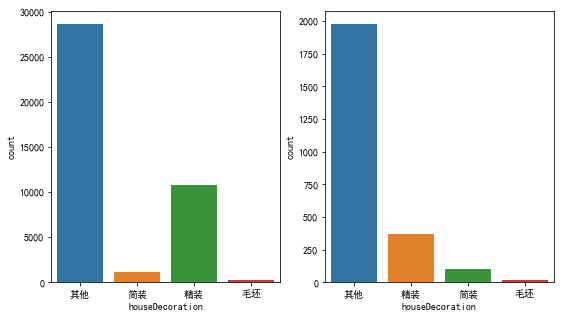

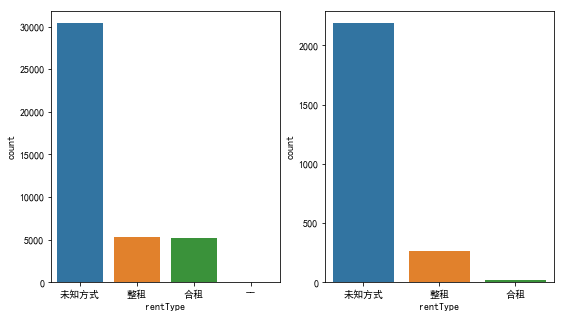

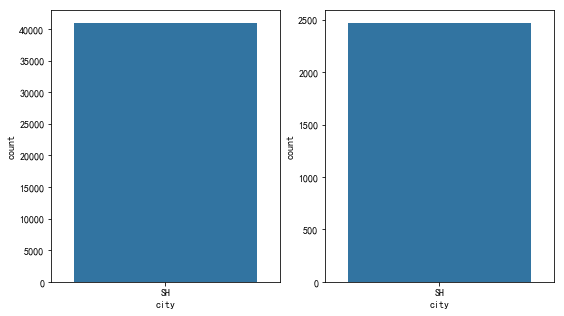

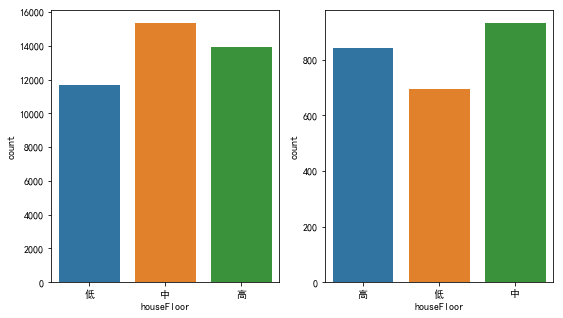

In [16]:
categorical_col_2 = ["houseType","houseToward","communityName","region","plate","buildYear","tradeTime"]
categorical_col_1 = set(categorical_col)-set(categorical_col_2)
for  col in categorical_col_1:
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,5))
    sns.countplot(x=col,data=train_df,ax=ax1)
    sns.countplot(x=col,data=test_df,ax=ax2)
    plt.show()

In [17]:
# for  col in categorical_col_2:
#     #fig,(ax1,ax2)= plt.subplots(1,2,figsize=(9,6))
#     fig = plt.figure(figsize=(12,9))
#     sns.countplot(x=col,data=train_df)
#     #plt.xticks(rotation=90)
#     #sns.countplot(x=col,data=test_df,ax=ax2)
#     plt.xticks(rotation=90)
#     plt.show()

### 5.Numerical特征的分布

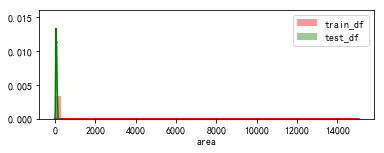

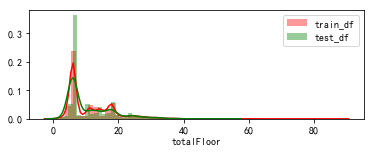

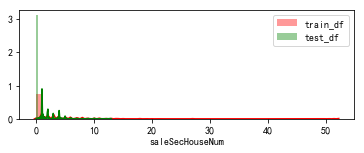

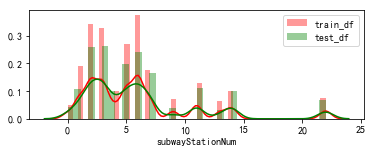

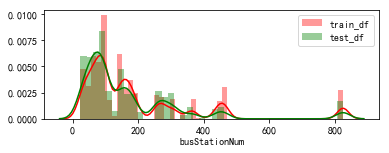

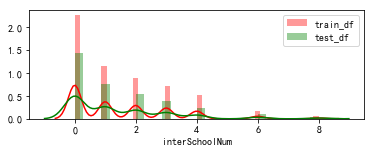

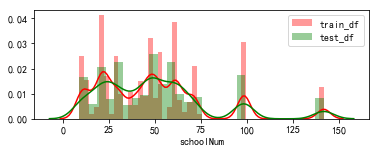

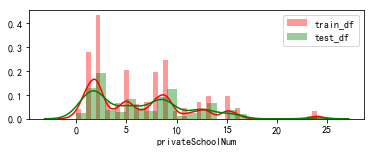

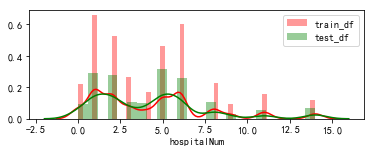

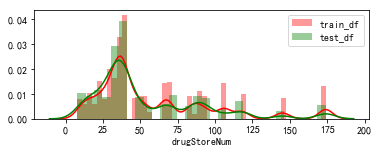

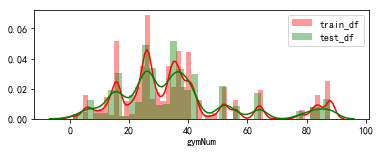

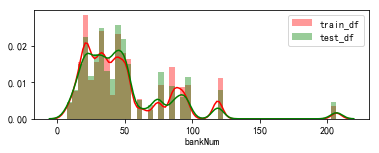

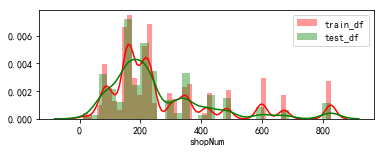

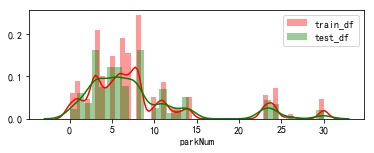

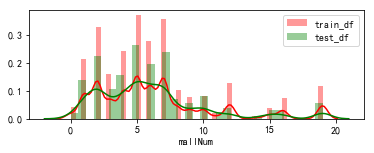

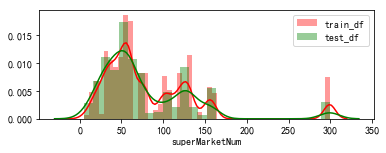

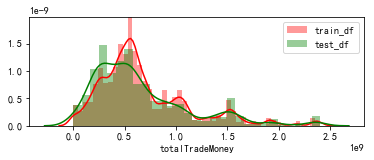

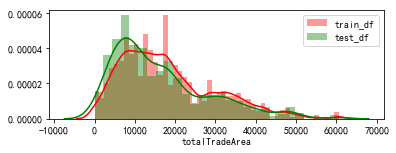

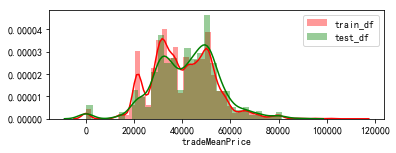

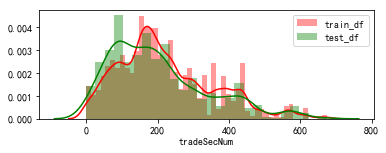

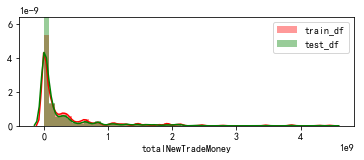

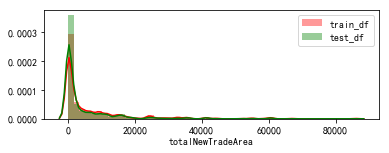

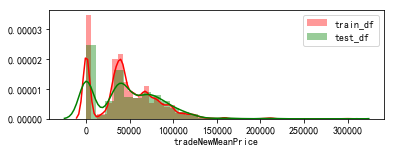

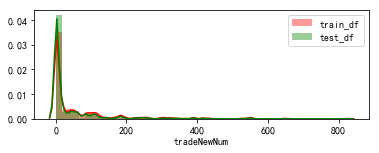

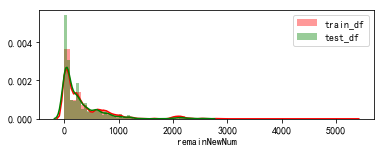

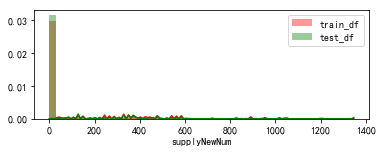

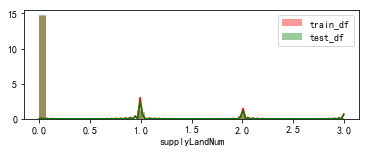

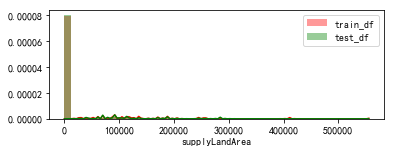

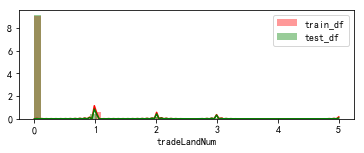

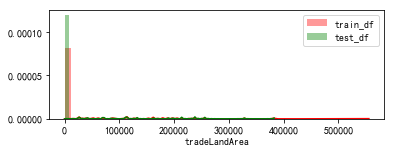

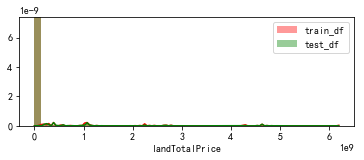

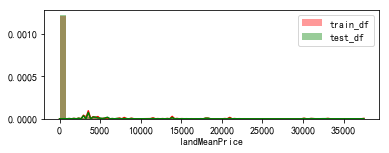

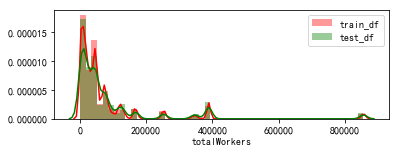

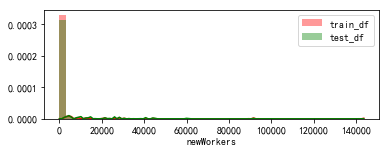

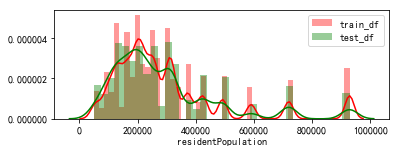

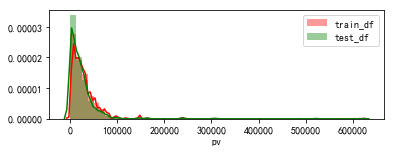

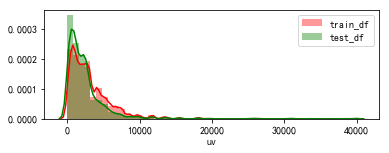

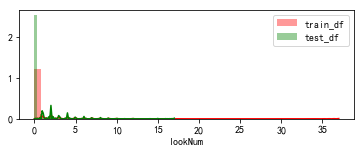

In [18]:
for num in numerical_col:
    fig = plt.figure(figsize=(6,2))
    sns.distplot(train_df[num],color="r")
    sns.distplot(test_df[num],color="g")
    plt.legend(["train_df","test_df"])
    plt.show()

可以看到，有一些特征有明显的长尾现象，由部分离群点的存在而造成的

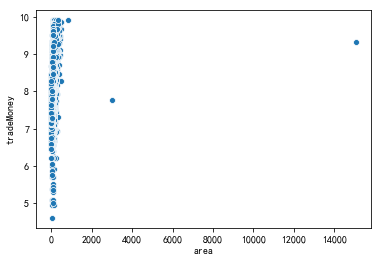

In [19]:
#--area--
sns.scatterplot(x="area",y="tradeMoney",data=train_df)
plt.show()

In [20]:
print("train area describe:")
print(train_df["area"].describe())
print("--------------------------------------------")
print("test area describe:")
print(test_df["area"].describe())

train area describe:
count    40940.000000
mean        68.829162
std         85.459402
min          1.000000
25%         42.290000
50%         64.270000
75%         89.510000
max      15055.000000
Name: area, dtype: float64
--------------------------------------------
test area describe:
count    2469.000000
mean       76.031839
std        29.080334
min        15.000000
25%        53.000000
50%        73.160000
75%        94.320000
max       150.000000
Name: area, dtype: float64


通过训练集，可以看出，area的最大值为150

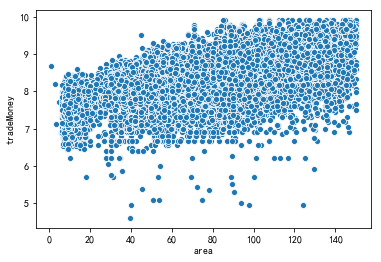

In [21]:
train_df = train_df[train_df["area"]<=150]
sns.scatterplot(x="area",y="tradeMoney",data=train_df)
plt.show()

#    -----------------------------------baseline--------------------------------

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
data_df = pd.concat([train_df,test_df],axis=0)

In [24]:
train_nunique = train_df[categorical_col].nunique().sort_values(ascending=False)
test_nunique = test_df[categorical_col].nunique().sort_values(ascending=False)
Total_nunique = pd.concat([train_nunique,test_nunique],axis=1,keys=["train_nunique","test_nunique"],sort=False)
Total_nunique

,train_nunique,test_nunique
communityName,3931,2469
tradeTime,361,331
buildYear,80,67
plate,66,63
houseType,57,31
region,15,14
houseToward,10,8
houseDecoration,4,4
rentType,4,3
houseFloor,3,3


In [25]:
data_df.drop(labels=["city","tradeMoney","ID","communityName"],axis=1,inplace=True)
data_df["rentType"].replace("--","未知方式",inplace=True)

In [26]:
#--buildyear--
data_df["buildYear"].replace("暂无信息",2019,inplace=True)
data_df["buildYear"] = data_df["buildYear"].astype(int)
data_df["buildYear"] = 2019-data_df["buildYear"]
data_df.drop("buildYear",axis=1,inplace=True)

#--houseType--
data_df["室"] = data_df["houseType"].apply(lambda x:x.split("室")[0][-1]).astype(int)
data_df["厅"] = data_df["houseType"].apply(lambda x:x.split("厅")[0][-1]).astype(int)
data_df["卫"] = data_df["houseType"].apply(lambda x:x.split("卫")[0][-1]).astype(int)
data_df.drop("houseType",axis=1,inplace=True)

#--tradeTime--
data_df["Month"] = data_df["tradeTime"].apply(lambda x:x.split("/")[1]).astype(int)
data_df["Day"] = data_df["tradeTime"].apply(lambda x:x.split("/")[2]).astype(int)
data_df.drop("tradeTime",axis=1,inplace=True)

In [27]:
categorical_col = [col for col in data_df.columns if data_df[col].dtypes=="object"]
columns_onehot = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration']
#onehotencoder
for index_1 in columns_onehot:
    data_df[index_1] = data_df[index_1].astype(str)
    inter_col = pd.get_dummies(data_df[index_1])
    data_df.drop(index_1,axis=1,inplace=True)
    data_df = pd.concat([data_df,inter_col],axis=1)
    
columns_label = set(categorical_col)-set(columns_onehot)
#labelencoder   
for index_2 in columns_label:
    data_df[index_2] = data_df[index_2].astype(str)
    data_df[index_2] = LabelEncoder().fit_transform(data_df[index_2])
    
#data_feature['buildYear'] = 2019-data_feature['buildYear']

In [28]:
print(train_df.shape)
print(test_df.shape)
print(data_df.shape)

(39719, 51)
(2469, 50)
(42188, 65)


In [29]:
#train and test
m = len(train_df["tradeMoney"])
X = data_df.iloc[:m,:]
Y = np.expm1(train_df["tradeMoney"])
X_test = data_df.iloc[m:,:]

In [30]:
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold,cross_val_score,GridSearchCV
import time

params = {
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [31]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_lgb = np.zeros(len(X))
predictions_lgb = np.zeros((len(X_test)))
start = time.time()
#feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, Y.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X.iloc[trn_idx],label=Y.iloc[trn_idx])
    
    val_data = lgb.Dataset(X.iloc[val_idx],label=Y.iloc[val_idx])
    

    num_round = 10000
    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
        
    oof_lgb[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV Score: {:<8.5f}".format(r2_score( Y, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 903.236	valid_1's rmse: 943.141
[1000]	training's rmse: 824.662	valid_1's rmse: 914.655
[1500]	training's rmse: 776.298	valid_1's rmse: 907.823
[2000]	training's rmse: 739.477	valid_1's rmse: 903.9
[2500]	training's rmse: 708.545	valid_1's rmse: 900.825
[3000]	training's rmse: 682.796	valid_1's rmse: 899.834
[3500]	training's rmse: 660.18	valid_1's rmse: 898.069
[4000]	training's rmse: 639.573	valid_1's rmse: 897.368
[4500]	training's rmse: 621.117	valid_1's rmse: 897.133
Early stopping, best iteration is:
[4504]	training's rmse: 620.96	valid_1's rmse: 897.085
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 898.991	valid_1's rmse: 965.61
[1000]	training's rmse: 821.452	valid_1's rmse: 936.706
[1500]	training's rmse: 774.401	valid_1's rmse: 928.043
[2000]	training's rmse: 738.061	valid_1's rmse: 922.899
[2500]	training's rmse: 708.533	valid_1's rm

In [32]:
# from sklearn.model_selection import train_test_split
# x_train,x_valid,y_train,y_valid = train_test_split(X,Y,train_size=0.8,test_size=0.2,random_state=20190816)

In [33]:
# import lightgbm as lgb
# from sklearn.metrics import r2_score
# lgb_model = lgb.LGBMRegressor(boosting_type="gbdt", objective='regression',metric='mse')
# lgb_model.fit(x_train, y_train,
#               eval_set=[(x_train, y_train),(x_valid, y_valid)],
#               early_stopping_rounds=100)

In [34]:
# '''线下'''
# pred_train = lgb_model.predict(x_train)
# train_loss = r2_score(y_train,pred_train)
# print("train r2 score:{}".format(train_loss))

# pred_test = lgb_model.predict(x_valid)
# test_loss = r2_score(y_valid,pred_test)
# print("test r2 score:{}".format(test_loss))

In [35]:
def online_score(pred):
    print("预测结果最大值：{},预测结果最小值：{}".format(pred.max(),pred.min()))
    # a榜测分
    conmbine1 = pd.read_csv("D:/DataAnalysis/2019未来高校AI挑战赛_城市-房产租金预测/sub_a_913.csv",engine = "python",header=None)
    score1 = r2_score(pred, conmbine1.values)
    print("对比913分数:{}".format(score1))

In [36]:
online_score(predictions_lgb)

预测结果最大值：17834.914754988084,预测结果最小值：1211.8783653457676
对比913分数:0.9302802901189646
